## 1. Import libraries and data

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

Importing the data takes a while (34sec), you must change the file path!

In [166]:
file_path = r"C:\Users\wagne\OneDrive\Documents\01_Etudes\03_ETHZ\05_MA3\01_Strassenverkehrssicherheit\Projekt\2025_Vorlesung-SVS_Hausarbeit_Daten\2025_Vorlesung-SVS_Hausarbeit_Daten\svu14-23.csv"
df = pd.read_csv(file_path, encoding='latin1', delimiter=',')

Here you can see all the columns that the data has!

In [167]:
df.columns.tolist()

['UnfallUID',
 'EreignisOID',
 'Quelle',
 'Unfalljahr',
 'Unfalldatum',
 'Unfallzeit',
 'Unfallmonat',
 'Feiertag',
 'Unfallkanton',
 'EreignisTotalBeteiligte',
 'EreignisTotalObjekte',
 'EreignisTotalPersonen',
 'Unfalltypengruppe',
 'Unfalltyp',
 'Sachschaden',
 'Hauptursachengruppe',
 'Hauptursachenuntergruppe',
 'Hauptursache',
 'InnerortsAusserorts',
 'Ortslage',
 'xKoordinate',
 'yKoordinate',
 'Autobahnname',
 'Gemeindenummer',
 'GemeindeText',
 'Ortschaft',
 'Strassenart',
 'StrassenartZusatz_1',
 'StrassenartZusatz_2',
 'StrassenartZusatz_3',
 'Strassenkategorie',
 'Zonensignalisation',
 'Höchstgeschwindigkeit',
 'HöchstgeschwindigkeitZusatz_1',
 'HöchstgeschwindigkeitZusatz_2',
 'Unfallstelle',
 'UnfallstelleZusatz_1',
 'UnfallstelleZusatz_2',
 'UnfallstelleZusatz_3',
 'UnfallstelleZusatz_4',
 'UnfallstelleZusatz_5',
 'UnfallstelleZusatz_6',
 'Vortrittsregelung',
 'VortrittsregelungZusatz_1',
 'VortrittsregelungZusatz_2',
 'Verkehrsaufkommen',
 'Witterung',
 'Witterungzusatz_

We don't need all of them, so we keep the relevant columns (it will make the code faster and more understandable)

In [197]:
columns_to_keep = [
    'UnfallUID', 'Unfalljahr', 'Alter', 'Hauptursache', 'Unfallfolgen', 'Hauptverursacher','Unfalltyp','Personenart','Unfallkanton'
]
df_filt = df[columns_to_keep]

## 2. Data analysis

#### 2.1 Senioren in den gesamten Verkehrsunfälle

In this part we try to understand what seniors represent globally for accidents.

Age bins + population reference (percentage):

In [198]:
bins = [0, 19, 64, 150]
labels = ["0-19", "20-64", "65+"]

df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=bins, labels=labels, right=True)

population_ref = pd.Series({
    "0-19": 19.9,
    "20-64": 60.6,
    "65+": 19.6
})

acc_counts = df_filt["age_group"].value_counts().reindex(labels)
acc_percentage = acc_counts / acc_counts.sum() * 100

C:\Users\wagne\AppData\Local\Temp\ipykernel_27732\2766907346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
C:\Users\wagne\AppData\Local\Temp\ipykernel_27732\2766907346.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=bins, labels=labels, right=True)


Plot 1 (total counts)

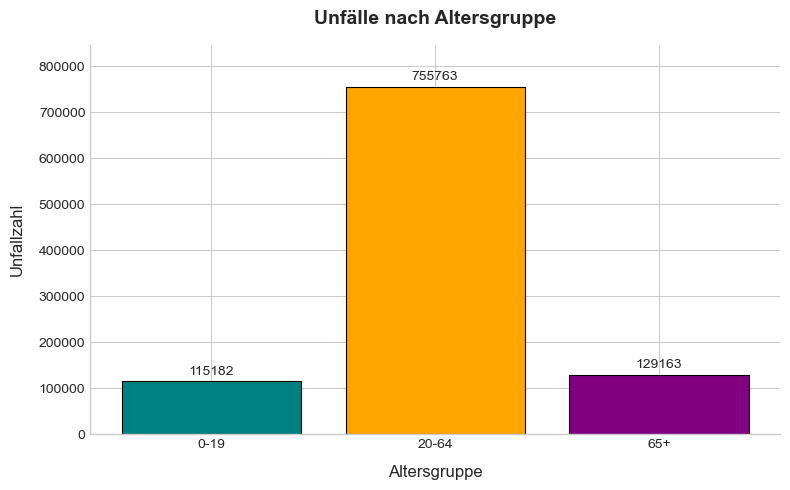

In [199]:
plt.style.use("seaborn-v0_8-whitegrid")   # clean professional base style

fig, ax = plt.subplots(figsize=(8, 5))

# Professional color palette (muted, consistent)
colors = ["#008080", "#FFA500", "#800080"]

bars = ax.bar(
    acc_counts.index,
    acc_counts.values,
    color=colors,
    edgecolor="black",
    linewidth=0.8
)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + max(acc_counts.values) * 0.01,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="medium"
    )

# Titles & labels
ax.set_xlabel("Altersgruppe", fontsize=12, labelpad=10)
ax.set_ylabel("Unfallzahl", fontsize=12, labelpad=10)
ax.set_title("Unfälle nach Altersgruppe", fontsize=14, fontweight="bold", pad=15)

# Make ticks cleaner
ax.tick_params(axis="both", labelsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Slightly increase y-limit for label spacing
ax.set_ylim(0, max(acc_counts.values) * 1.12)

plt.tight_layout()
plt.show()

Plot 2 (Distribution)

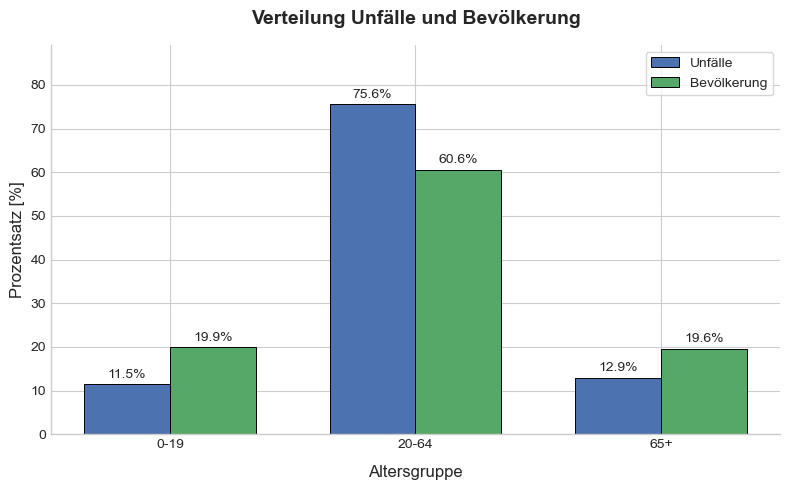

In [200]:
fig, ax = plt.subplots(figsize=(8, 5))

width = 0.35
x = range(len(labels))

# Muted, professional palette
color_acc = "#4C72B0"
color_pop = "#55A868"

bars1 = ax.bar(
    [i - width/2 for i in x],
    acc_percentage.values,
    width=width,
    label="Unfälle",
    color=color_acc,
    edgecolor="black",
    linewidth=0.7
)

bars2 = ax.bar(
    [i + width/2 for i in x],
    population_ref.values,
    width=width,
    label="Bevölkerung",
    color=color_pop,
    edgecolor="black",
    linewidth=0.7
)

# Nicely formatted % labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + max(max(acc_percentage.values), max(population_ref.values)) * 0.01,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="medium"
        )

add_labels(bars1)
add_labels(bars2)

# Styling axes
ax.set_xticks(list(x))
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel("Altersgruppe", fontsize=12, labelpad=10)
ax.set_ylabel("Prozentsatz [%]", fontsize=12)
ax.set_title(
    "Verteilung Unfälle und Bevölkerung",
    fontsize=14,
    fontweight="bold",
    pad=15
)

# Remove unnecessary spines for cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis="y", labelsize=10)

ax.legend(frameon=True, fontsize=10)

# Add a bit of headroom above bars
ax.set_ylim(0, max(max(acc_percentage.values), max(population_ref.values)) * 1.18)

plt.tight_layout()
plt.show()

In [201]:
mapping = {
    "nicht verletzt": "nicht / leicht verletzt / unbekannt",
    "schwer verletzt (vor 2015)": "erheblich / schwer verletzt",
    "unbekannt": "nicht / leicht verletzt / unbekannt",
    "leicht verletzt": "nicht / leicht verletzt",
    "auf Platz gestorben": "lebensdrohlich / tödlich",
    "innert 30 Tagen gestorben": "lebensdrohlich / tödlich",
    "erheblich verletzt": "erheblich / schwer verletzt",
    "lebensdrohlich verletzt": "lebensdrohlich / tödlich"
}

In [202]:
df_filt["Unfallfolgen_Gruppen"] = df_filt["Unfallfolgen"].map(mapping)

C:\Users\wagne\AppData\Local\Temp\ipykernel_27732\2083952365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["Unfallfolgen_Gruppen"] = df_filt["Unfallfolgen"].map(mapping)


In [203]:
df_severe = df_filt[df_filt["Unfallfolgen_Gruppen"] == "lebensdrohlich / tödlich"].copy()

sev_counts = df_severe["age_group"].value_counts().reindex(labels, fill_value=0)

sev_percentage = sev_counts / sev_counts.sum() * 100

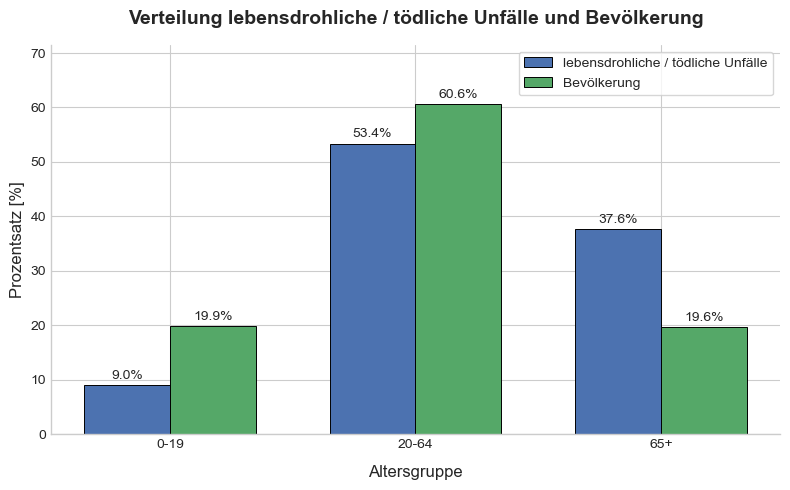

In [204]:
fig, ax = plt.subplots(figsize=(8, 5))

width = 0.35
x = range(len(labels))

# Colors
color_acc = "#4C72B0"
color_pop = "#55A868"

# Bars
bars1 = ax.bar(
    [i - width/2 for i in x],
    sev_percentage.values,
    width=width,
    label="lebensdrohliche / tödliche Unfälle",
    color=color_acc,
    edgecolor="black",
    linewidth=0.7
)

bars2 = ax.bar(
    [i + width/2 for i in x],
    population_ref.values,
    width=width,
    label="Bevölkerung",
    color=color_pop,
    edgecolor="black",
    linewidth=0.7
)

# Add percentage labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + max(max(sev_percentage.values), max(population_ref.values)) * 0.01,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="medium"
        )

add_labels(bars1)
add_labels(bars2)

# Axes labels and title
ax.set_xticks(list(x))
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel("Altersgruppe", fontsize=12, labelpad=10)
ax.set_ylabel("Prozentsatz [%]", fontsize=12)
ax.set_title(
    "Verteilung lebensdrohliche / tödliche Unfälle und Bevölkerung",
    fontsize=14,
    fontweight="bold",
    pad=15
)

# Remove top/right spines for cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="y", labelsize=10)

# Legend
ax.legend(frameon=True, fontsize=10)

# Add headroom above bars
ax.set_ylim(0, max(max(sev_percentage.values), max(population_ref.values)) * 1.18)

plt.tight_layout()
plt.show()

In [205]:
# Compute counts of 'ja'/'nein' per age group
responsibility_counts = df_filt.groupby(["age_group", "Hauptverursacher"]).size().unstack(fill_value=0)

# Convert to percentages
responsibility_pct = responsibility_counts.div(responsibility_counts.sum(axis=1), axis=0) * 100


C:\Users\wagne\AppData\Local\Temp\ipykernel_27732\3928786307.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  responsibility_counts = df_filt.groupby(["age_group", "Hauptverursacher"]).size().unstack(fill_value=0)


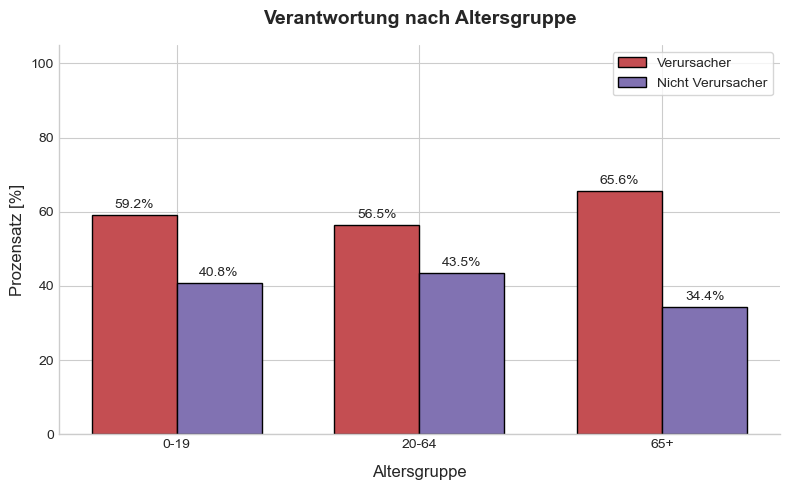

In [206]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
x = range(len(labels))

bars1 = ax.bar(
    [i - width/2 for i in x],
    responsibility_pct["ja"].values,
    width=width,
    label="Verursacher",
    color="#C44E52",
    edgecolor="black"
)

bars2 = ax.bar(
    [i + width/2 for i in x],
    responsibility_pct["nein"].values,
    width=width,
    label="Nicht Verursacher",
    color="#8172B2",
    edgecolor="black"
)

# Add percentage labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="medium"
        )

add_labels(bars1)
add_labels(bars2)

# Labels, title, legend
ax.set_xticks(list(x))
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel("Altersgruppe", fontsize=12, labelpad=10)
ax.set_ylabel("Prozensatz [%]", fontsize=12)
ax.set_title("Verantwortung nach Altersgruppe", fontsize=14, fontweight="bold", pad=15)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="y", labelsize=10)

ax.legend(frameon=True, fontsize=10)

ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

#### 2.2 Forschungsfrage

First we try to study what these obligatorische Untersuchungen try to do (ie. what kind/how many accidents they could help prevent). Since they only impact people's driving licenses, only Personenart "Lenker/in" matter. Furthermore, only people 70+, since 2019 75+ have to do this Untersuchung.

In [207]:
df_filt["Personenart"].unique()

array(['Lenker/in', 'Mitfahrer/in vorne', 'Mitfahrer/in hinten',
       'Fussgänger/in', 'FäG', 'Mitfahrer/in unbekannt'], dtype=object)

In [208]:
df_old = df_filt[df_filt["Alter"] >= 65] 

total_accidents = len(df_old)
lenker_70_74 = df_old[(df_old["Personenart"] == "Lenker/in") & (df_old["Alter"].between(70, 74))]
lenker_75_plus = df_old[(df_old["Personenart"] == "Lenker/in") & (df_old["Alter"] >= 75)]

counts = [
    total_accidents - len(lenker_70_74) - len(lenker_75_plus), 
    len(lenker_70_74),
    len(lenker_75_plus)
]

labels = ["Andere Unfälle (65+)", "Lenker/in (70–74)", "Lenker/in (75+)"]
colors = ["#C4C4C4", "#008080", "#FFA500"]  # neutral + teal + orange


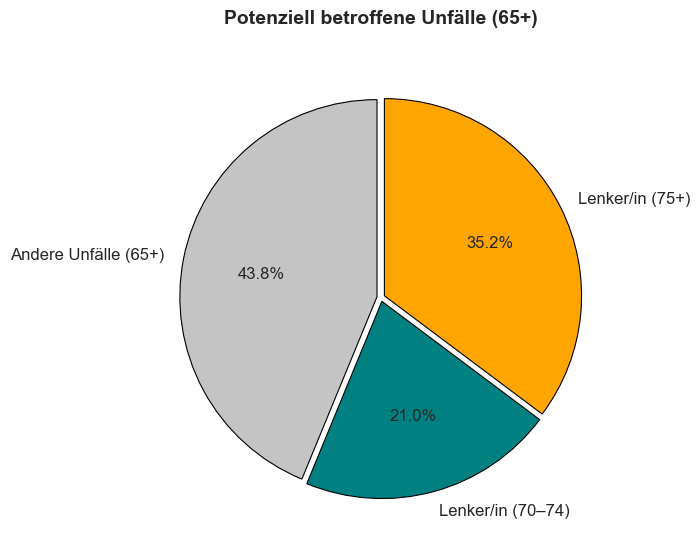

In [209]:
plt.style.use("seaborn-v0_8-whitegrid")  # clean professional style

# Explode slices for emphasis on older drivers
explode = [0.02, 0.02, 0.02]  # slightly pull out the relevant slices

plt.figure(figsize=(7,7))
plt.pie(
    counts,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'weight': 'medium'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.8}
)

plt.title(
    "Potenziell betroffene Unfälle (65+)",
    fontsize=14,
    fontweight="bold",
    pad=20
)

plt.tight_layout()
plt.show()

In [210]:
plt.style.use("seaborn-v0_8-whitegrid")

years = sorted(df_filt["Unfalljahr"].unique())

# Compute counts
total = []
drivers_65 = []
drivers_70 = []
drivers_75 = []

for year in years:
    df_year = df_filt[df_filt["Unfalljahr"] == year]
    total.append(len(df_year))
    drivers_65.append(len(df_year[(df_year["Personenart"] == "Lenker/in") & (df_year["Alter"] >= 65) & (df_year["Alter"] <= 69)]))
    drivers_70.append(len(df_year[(df_year["Personenart"] == "Lenker/in") & (df_year["Alter"] >= 70) & (df_year["Alter"] <= 74)]))
    drivers_75.append(len(df_year[(df_year["Personenart"] == "Lenker/in") & (df_year["Alter"] >= 75)]))


In [211]:
pop_path = r"C:\Users\wagne\OneDrive\Documents\01_Etudes\03_ETHZ\05_MA3\01_Strassenverkehrssicherheit\Projekt\Datenanalyse\Bevölkerung.csv"
df_pop = pd.read_csv(pop_path, encoding='latin1', delimiter=',')

In [212]:
# Compute populations
pop_all = df_pop[df_pop["Alter"] == "Alter - Total"].iloc[:, 2:]  # select only year columns
pop_all = pop_all.values.flatten().tolist()  # convert to list

pop_65_plus = df_pop[df_pop["Alter"].str.contains("65|66|67|68|69")].iloc[:,2:].sum()
pop_70_plus = df_pop[df_pop["Alter"].str.contains("70|71|72|73|74")].iloc[:,2:].sum()
pop_75_plus = df_pop[df_pop["Alter"].str.contains("75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99")].iloc[:,2:].sum()

pop_65_plus = pop_65_plus.tolist()
pop_70_plus = pop_70_plus.tolist()
pop_75_plus = pop_75_plus.tolist()


OK so this is actually hard to understand. Let's try to dig deeper into possible effects.

In [213]:
rate_65 = [a / p * 100 for a, p in zip(drivers_65, pop_65_plus)]
rate_70 = [a / p * 100 for a, p in zip(drivers_70, pop_70_plus)]
rate_75 = [a / p * 100 for a, p in zip(drivers_75, pop_75_plus)]

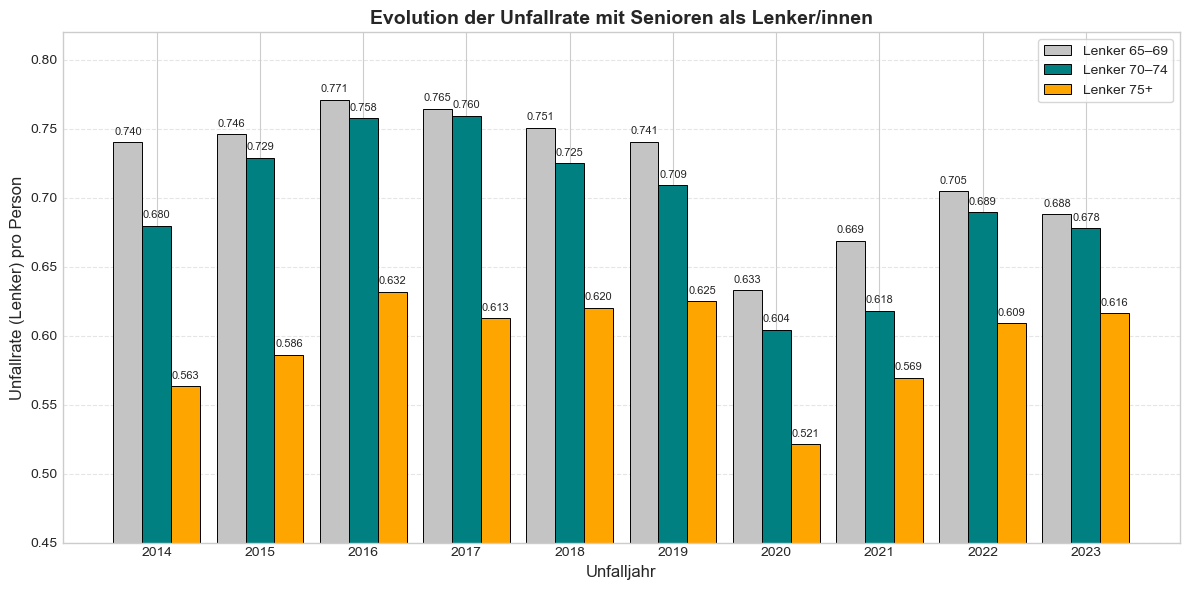

In [214]:
plt.style.use("seaborn-v0_8-whitegrid")

x = np.arange(len(years))
width = 0.28

fig, ax = plt.subplots(figsize=(12, 6))

# ================================
# Improved bar styling
# ================================
bars_65 = ax.bar(
    x - width, rate_65, width=width,
    color="#C4C4C4", edgecolor="black", linewidth=0.7,
    label="Lenker 65–69"
)

bars_70 = ax.bar(
    x, rate_70, width=width,
    color="#008080", edgecolor="black", linewidth=0.7,
    label="Lenker 70–74"
)

bars_75 = ax.bar(
    x + width, rate_75, width=width,
    color="#FFA500", edgecolor="black", linewidth=0.7,
    label="Lenker 75+"
)

# ================================
# Add labels above bars
# ================================
for bars in [bars_65, bars_70, bars_75]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.004,
            f"{height:.3f}",
            ha='center', va='bottom',
            fontsize=8
        )

# ================================
# Axes & look
# ================================
ax.set_xlabel("Unfalljahr", fontsize=12)
ax.set_ylabel("Unfallrate (Lenker) pro Person", fontsize=12)

ax.set_title(
    "Evolution der Unfallrate mit Senioren als Lenker/innen",
    fontsize=14, fontweight="bold"
)

ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_ylim(0.45, 0.82)

ax.grid(axis='y', linestyle='--', alpha=0.5)

# Clean legend
ax.legend(frameon=True, fontsize=10)

plt.tight_layout()
plt.show()


In [215]:
resp_65 = []
resp_70 = []
resp_75 = []

for year in years:
    df_year = df_filt[df_filt["Unfalljahr"] == year]
    
    resp_65.append(len(df_year[
        (df_year["Personenart"] == "Lenker/in") &
        (df_year["Alter"] >= 65) & (df_year["Alter"] <= 69) &
        (df_year["Hauptverursacher"] == "ja")   # responsible only
    ]))
    
    resp_70.append(len(df_year[
        (df_year["Personenart"] == "Lenker/in") &
        (df_year["Alter"] >= 70) & (df_year["Alter"] <= 74) &
        (df_year["Hauptverursacher"] == "ja")
    ]))
    
    resp_75.append(len(df_year[
        (df_year["Personenart"] == "Lenker/in") &
        (df_year["Alter"] >= 75) &
        (df_year["Hauptverursacher"] == "ja")
    ]))

# ---------------------------
# Compute rates for responsible drivers
# ---------------------------
rate_resp_65 = [a / p * 100 for a, p in zip(resp_65, pop_65_plus)]
rate_resp_70 = [a / p * 100 for a, p in zip(resp_70, pop_70_plus)]
rate_resp_75 = [a / p * 100 for a, p in zip(resp_75, pop_75_plus)]

In [216]:
age_groups = {
    "65-69": (65, 69),
    "70-74": (70, 74),
    "75+":   (75, 200)
}

# Prepare data structure
resp_share = {g: {"ja": [], "nein": []} for g in age_groups}

# Compute % responsibility per year and per group
for year in years:
    df_y = df_filt[(df_filt["Unfalljahr"] == year) & (df_filt["Personenart"]=="Lenker/in")]

    for g, (a_min, a_max) in age_groups.items():
        df_group = df_y[(df_y["Alter"] >= a_min) & (df_y["Alter"] <= a_max)]

        total = len(df_group)
        if total == 0:
            resp_share[g]["ja"].append(0)
            resp_share[g]["nein"].append(0)
            continue

        ja_count = len(df_group[df_group["Hauptverursacher"]=="ja"])
        nein_count = len(df_group[df_group["Hauptverursacher"]=="nein"])

        resp_share[g]["ja"].append(ja_count * 100 / total)
        resp_share[g]["nein"].append(nein_count * 100 / total)


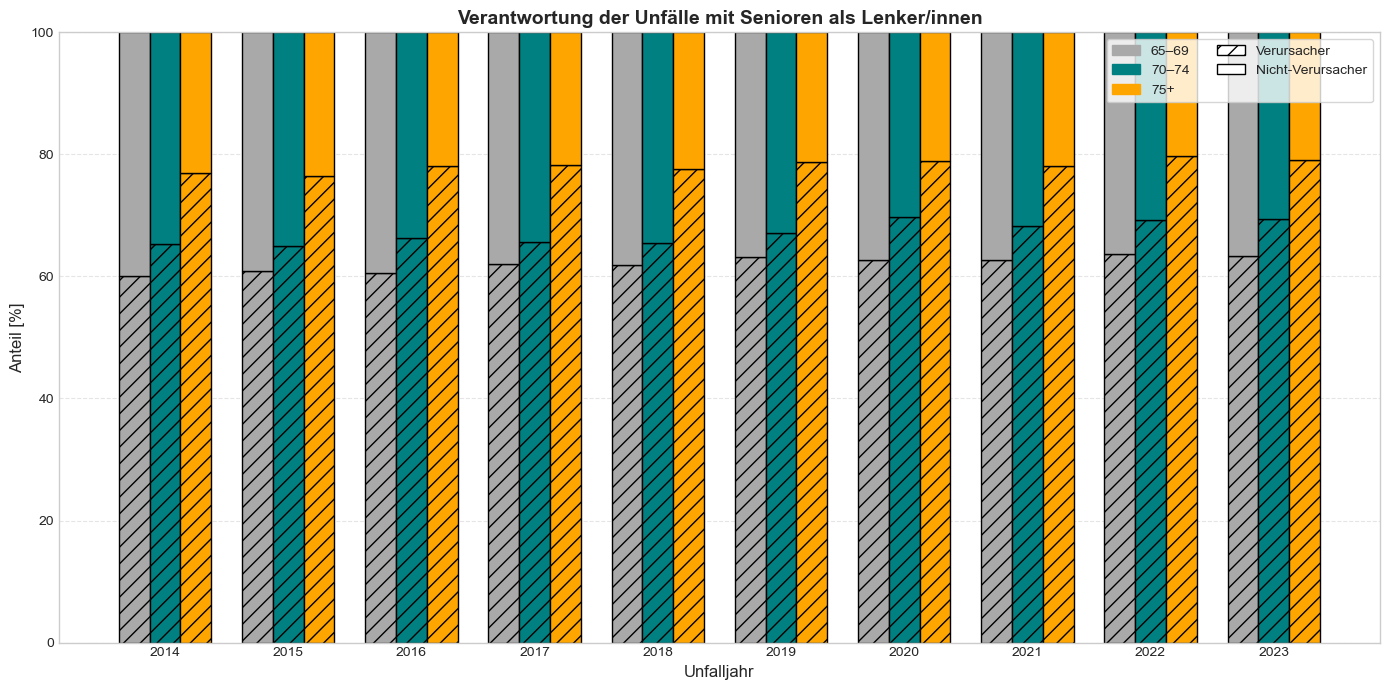

In [217]:
plt.style.use("seaborn-v0_8-whitegrid")

x = np.arange(len(years))
width = 0.25

fig, ax = plt.subplots(figsize=(14,7))

# Base colors for age groups
colors = {
    "65-69": "#A9A9A9",   # grey
    "70-74": "#008080",   # teal
    "75+":   "#FFA500"    # orange
}

# One unified hatch pattern for Verursacher
hatch_pattern = "//"

offsets = [-width, 0, width]

for (g, off) in zip(age_groups.keys(), offsets):

    ja_vals   = resp_share[g]["ja"]
    nein_vals = resp_share[g]["nein"]

    # Verursacher (hatched)
    ax.bar(x + off, ja_vals, width,
           color=colors[g],
           edgecolor="black",
           hatch=hatch_pattern)

    # Nicht-Verursacher (solid)
    ax.bar(x + off, nein_vals, width,
           bottom=ja_vals,
           color=colors[g],
           edgecolor="black")

# Labels & axes
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_xlabel("Unfalljahr", fontsize=12)
ax.set_ylabel("Anteil [%]", fontsize=12)
ax.set_title("Verantwortung der Unfälle mit Senioren als Lenker/innen",
             fontsize=14, fontweight="bold")

ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# ---- CUSTOM CLEAN LEGEND ----

import matplotlib.patches as mpatches

# Age-group patches (solid)
lg_age = [
    mpatches.Patch(color=colors["65-69"], label="65–69"),
    mpatches.Patch(color=colors["70-74"], label="70–74"),
    mpatches.Patch(color=colors["75+"],   label="75+"),
]

# Responsibility patches (white background)
lg_resp = [
    mpatches.Patch(facecolor="white", edgecolor="black",
                   hatch=hatch_pattern, label="Verursacher"),
    mpatches.Patch(facecolor="white", edgecolor="black",
                   label="Nicht-Verursacher")
]

# Combine
ax.legend(handles=lg_age + lg_resp,
          ncol=2, fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

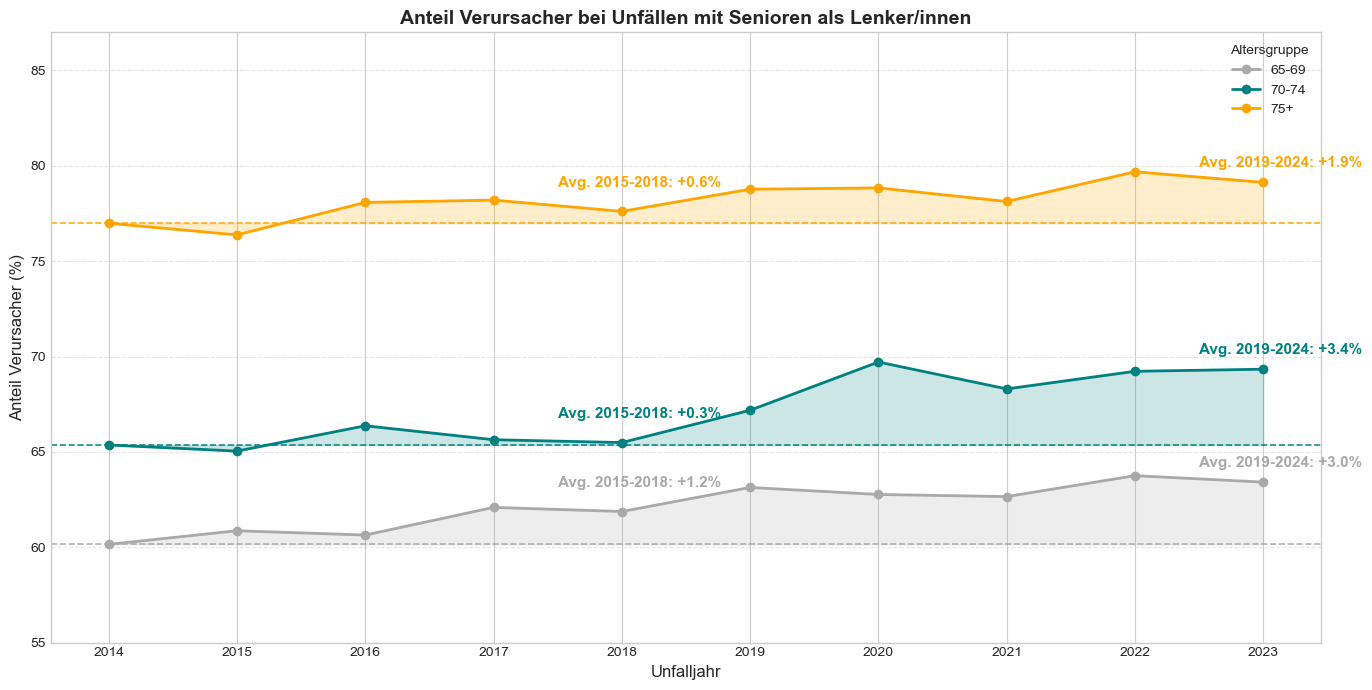

In [218]:
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(14,7))

# Base colors for age groups
colors = {
    "65-69": "#A9A9A9",   # grey
    "70-74": "#008080",   # teal
    "75+":   "#FFA500"    # orange
}

alpha_fill = 0.20

for g in age_groups.keys():
    ja_vals = resp_share[g]["ja"]           # % Verursacher
    baseline = ja_vals[0]                   # 2014 value
    years_arr = np.array(years)

    # ---- Main Line ----
    ax.plot(
        years, ja_vals,
        marker="o",
        linewidth=2,
        markersize=6,
        color=colors[g],
        label=f"{g}"
    )

    # ---- Horizontal dashed baseline ----
    ax.axhline(
        baseline,
        color=colors[g],
        linestyle="--",
        linewidth=1.2,
        alpha=0.9
    )

    # ---- Fill between curve and baseline ----
    ax.fill_between(
        years,
        ja_vals,
        baseline,
        color=colors[g],
        alpha=alpha_fill
    )

    # ---- Compute avg increase/decrease 2015–2018 vs 2014 ----
    mask_15_18 = (years_arr >= 2015) & (years_arr <= 2018)
    mean_15_18 = np.mean(np.array(ja_vals)[mask_15_18])
    diff_15_18 = mean_15_18 - baseline
    diff_text_15_18 = f"Avg. 2015-2018: {diff_15_18:+.1f}%"

    # ---- Compute avg increase/decrease 2019–2023 vs 2014 ----
    mask_19_23 = (years_arr >= 2019)
    mean_19_23 = np.mean(np.array(ja_vals)[mask_19_23])
    diff_19_23 = mean_19_23 - baseline
    diff_text_19_23 = f"Avg. 2019-2024: {diff_19_23:+.1f}%"

    # ---- Place text at the end of the line ----
    ax.text(
        years[-1]-0.5,
        ja_vals[-1] + 1,  # slightly above for 2019-2023
        diff_text_19_23,
        color=colors[g],
        fontsize=11,
        fontweight="bold",
        va="center"
    )
    ax.text(
        years[years.index(2018)]-0.5,
        ja_vals[years.index(2018)] + 1.5,  # slightly above for 2015-2018
        diff_text_15_18,
        color=colors[g],
        fontsize=11,
        fontweight="bold",
        va="center"
    )

# Labels, title, axes
ax.set_xlabel("Unfalljahr", fontsize=12)
ax.set_ylabel("Anteil Verursacher (%)", fontsize=12)
ax.set_title("Anteil Verursacher bei Unfällen mit Senioren als Lenker/innen",
             fontsize=14, fontweight="bold")

ax.set_xticks(years)
ax.set_ylim(55, 87)
ax.grid(axis='y', linestyle='--', alpha=0.5)

ax.legend(title="Altersgruppe", fontsize=10)

plt.tight_layout()
plt.show()

In [219]:
df_folgen = df_filt.copy()
df_folgen["Unfallfolgen_Gruppen"] = df_filt["Unfallfolgen"].map(mapping)

In [220]:
categories = ["nicht / leicht verletzt / unbekannt", "erheblich / schwer verletzt", "lebensdrohlich / tödlich"]
colors = ["#A9A9A9", "#FFA500", "#FF0000"]  # grey, orange, red

counts_pre  = df_folgen[df_folgen["Unfalljahr"] < 2019]["Unfallfolgen_Gruppen"].value_counts(normalize=True).reindex(categories, fill_value=0) * 100
counts_post = df_folgen[df_folgen["Unfalljahr"] >= 2019]["Unfallfolgen_Gruppen"].value_counts(normalize=True).reindex(categories, fill_value=0) * 100


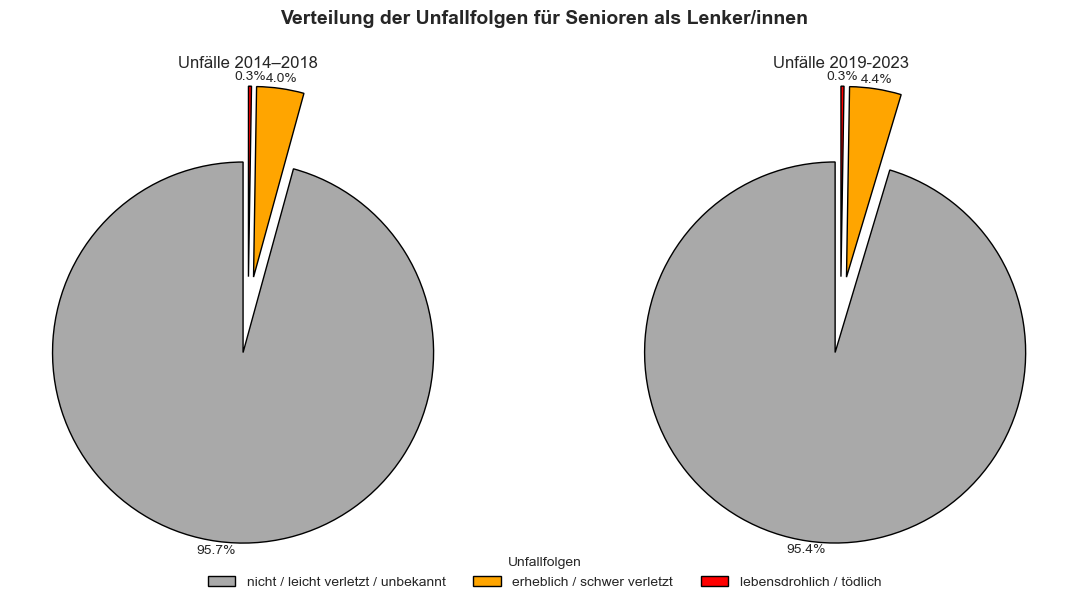

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
explode = [0.2, 0.2, 0.2]

# ---------------- Pre-2019 ----------------
wedges1, texts1, autotexts1 = axes[0].pie(
    counts_pre,
    labels=None,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor':'black'},
    pctdistance=1.05  # move percentages outside
)
axes[0].set_title("Unfälle 2014–2018")

# ---------------- Post-2019 ----------------
wedges2, texts2, autotexts2 = axes[1].pie(
    counts_post,
    labels=None,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor':'black'},
    pctdistance=1.05
)
axes[1].set_title("Unfälle 2019-2023")

# ---------------- Legend ----------------
fig.legend(
    wedges1, categories,
    title="Unfallfolgen",
    loc="lower center",
    ncol=len(categories),
    fontsize=10
)

plt.suptitle("Verteilung der Unfallfolgen für Senioren als Lenker/innen", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space at bottom for legend
plt.show()

In [222]:
import geopandas as gpd
import matplotlib.colors as colors

In [223]:
cantons = gpd.read_file(r"C:\Users\wagne\OneDrive\Documents\01_Etudes\03_ETHZ\05_MA3\01_Strassenverkehrssicherheit\Projekt\Datenanalyse\swissboundaries3d_2025-04_2056_5728.shp")

c:\Users\wagne\anaconda3\envs\gis-env\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'swissboundaries3d_2025-04_2056_5728.shp': 'swissBOUNDARIES3D_1_5_TLM_BEZIRKSGEBIET' (default), 'swissBOUNDARIES3D_1_5_TLM_HOHEITSGEBIET', 'swissBOUNDARIES3D_1_5_TLM_HOHEITSGRENZE', 'swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET', 'swissBOUNDARIES3D_1_5_TLM_LANDESGEBIET'. Specify layer parameter to avoid this warning.
  result = read_func(


In [224]:
cantons_only = cantons.dissolve(by="KANTONSNUM").reset_index()

In [225]:
kanton_map = {
    1: "ZH",
    2: "BE",
    3: "LU",
    4: "UR",
    5: "SZ",
    6: "OW",
    7: "NW",
    8: "GL",
    9: "ZG",
    10: "FR",
    11: "SO",
    12: "BS",
    13: "BL",
    14: "SH",
    15: "AR",
    16: "AI",
    17: "SG",
    18: "GR",
    19: "AG",
    20: "TG",
    21: "TI",
    22: "VD",
    23: "VS",
    24: "NE",
    25: "GE",
    26: "JU"
}

# Add canton codes to GeoDataFrame
cantons_only['KANTON_CODE'] = cantons_only['KANTONSNUM'].map(kanton_map)

In [226]:
age_groups_map = {
    "0-64": (0, 64),
    "65-69": (65, 69),
    "70-74": (70, 74),
    "75+":   (75, 200)
}
cantonal_change = pd.DataFrame(columns=["KANTON_CODE", "AGE_GROUP", "avg_increase"])

In [227]:
for num, code in kanton_map.items():
    for ag_name, (age_min, age_max) in age_groups_map.items():
        df_ag = df_filt[
            (df_filt["Alter"] >= age_min) & (df_filt["Alter"] <= age_max) &
            (df_filt["Personenart"]=="Lenker/in") &
            (df_filt["Unfallkanton"]==code)
        ]
        
        pre2019 = df_ag[df_ag["Unfalljahr"] < 2019].shape[0]
        post2019 = df_ag[df_ag["Unfalljahr"] >= 2019].shape[0]
        
        if pre2019 > 0:
            change = (post2019 - pre2019) / pre2019 * 100  # % increase/decrease
        else:
            change = np.nan
        
        cantonal_change = pd.concat([
            cantonal_change,
            pd.DataFrame([{"KANTON_CODE": code, "AGE_GROUP": ag_name, "avg_increase": change}])
        ], ignore_index=True)

C:\Users\wagne\AppData\Local\Temp\ipykernel_27732\129124509.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cantonal_change = pd.concat([


In [228]:
plots_data = {}
for ag in age_groups_map.keys():
    df_ag = cantonal_change[cantonal_change["AGE_GROUP"]==ag]
    gdf = cantons_only.merge(df_ag, on="KANTON_CODE", how="left")
    plots_data[ag] = gdf

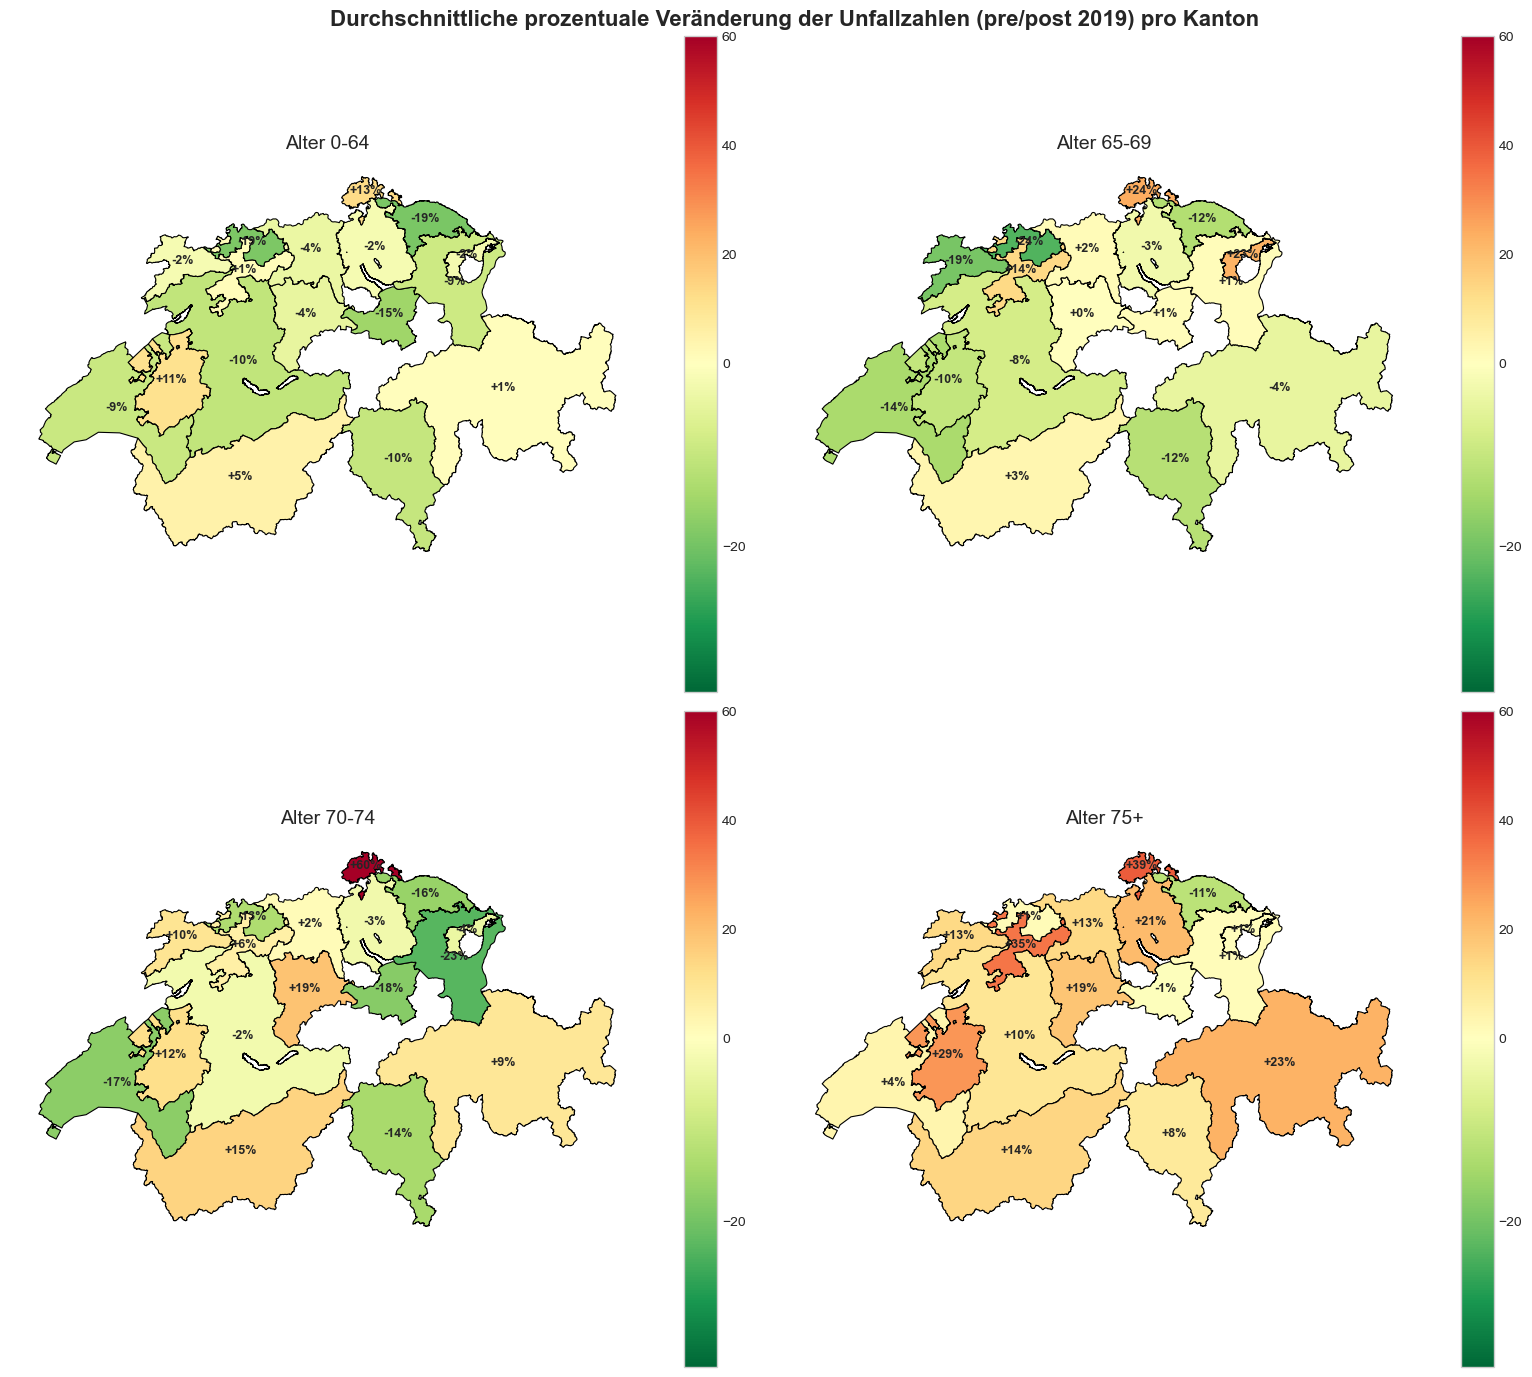

In [229]:
fig, axes = plt.subplots(2, 2, figsize=(16,14))
axes = axes.flatten()

# Use diverging colormap: red for +, green for -, centered at 0
cmap = plt.cm.RdYlGn_r  # reversed so red=positive, green=negative

# Define norm to center at 0
vmin = cantonal_change["avg_increase"].min()
vmax = cantonal_change["avg_increase"].max()
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i, ag in enumerate(age_groups_map.keys()):
    gdf = plots_data[ag]
    
    gdf.plot(
        column="avg_increase",
        cmap=cmap,
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=axes[i],
        norm=divnorm
    )
    
    # Annotate the % change on each canton
    for idx, row in gdf.iterrows():
        if not np.isnan(row["avg_increase"]):
            axes[i].text(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                f"{row['avg_increase']:+.0f}%",
                horizontalalignment='center',
                fontsize=9,
                weight='bold'
            )
    
    axes[i].set_title(f"Alter {ag}", fontsize=14)
    axes[i].axis("off")

plt.suptitle(
    "Durchschnittliche prozentuale Veränderung der Unfallzahlen (pre/post 2019) pro Kanton",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()